In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re

In [ ]:
df = pd.read_csv('upsampled.csv')
#dropping unwanted axis
df.drop(["image_name", "text_ocr"], 
          axis=1,
          inplace=True)

In [ ]:
df['offensive'].value_counts()

not_offensive        2713
slight               2592
very_offensive       1466
hateful_offensive    1324
Name: offensive, dtype: int64

In [ ]:
#If any field is empty than remove it
df.isnull().values.any()
df= df.dropna()

In [ ]:
labels = df['offensive'].map(lambda x : 0 if x== 'not_offensive' else 1)

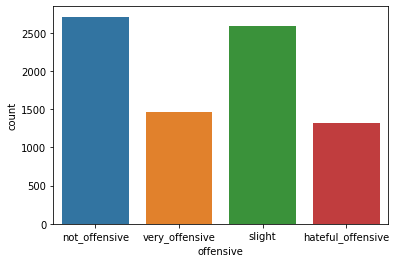

In [ ]:
#data visualization
import seaborn as sns

sns.countplot(x='offensive', data=df)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

import re
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stop = set(stopwords.words("english"))
    text = [w for w in text if not w in stop and len(w) >= 3] 
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[a-z A-Z]*@[a-z]*\.(com)"," ", text) # to remove email ids
    text = re.sub(r"\w*\.com\b"," ", text) #to remove domains
    text = re.sub(r"\d{10}"," ", text) #to remove 10 digit phone number
    text = re. sub(r"[A-z a-z]acebook| [A-z a-z]witter | [A-z a-z]nstagram", " ", text)
    text = re.sub(r"\d\d\d\d", " ", text) #year
    text = re.sub(r"\d", " ", text) #removing digits
    text = re.sub(r"likes| follow| comment|share", " ", text)
    text = re.sub(r"\+|\-|\*|\?", " ", text)
 
    return text
# apply the above function to df['text']
df['text_corrected'] = df['text_corrected'].map(lambda x: clean_text(x))

In [ ]:

### Create sequence
vocabulary_size = 10000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text_corrected'])
sequences = tokenizer.texts_to_sequences(df['text_corrected'])
data = pad_sequences(sequences, maxlen=15)

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-06-16 10:12:52--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-16 10:12:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip         12%[=>                  ] 106.71M  2.15MB/s    eta 3m 19s 

In [ ]:

f = open('glove.840B.300d.txt', encoding = 'utf8') 
embeddings_index = dict()
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

FileNotFoundError: ignored

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

NameError: ignored

In [ ]:
## creating model using CNN
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 300, input_length=15, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_glove.fit(data, np.array(labels), validation_split=0.50, epochs = 5)

Train on 3493 samples, validate on 3494 samples
Epoch 1/5
3493/3493 [==============================] - 1s 241us/step - loss: 0.1209 - accuracy: 0.9339 - val_loss: 1.3652 - val_accuracy: 0.7064
Epoch 2/5
3493/3493 [==============================] - 1s 243us/step - loss: 0.1191 - accuracy: 0.9339 - val_loss: 1.3756 - val_accuracy: 0.7075
Epoch 3/5
3493/3493 [==============================] - 1s 242us/step - loss: 0.1258 - accuracy: 0.9304 - val_loss: 1.3066 - val_accuracy: 0.7112
Epoch 4/5
3493/3493 [==============================] - 1s 244us/step - loss: 0.1196 - accuracy: 0.9336 - val_loss: 1.3870 - val_accuracy: 0.7066
Epoch 5/5
3493/3493 [==============================] - 1s 243us/step - loss: 0.1165 - accuracy: 0.9344 - val_loss: 1.4058 - val_accuracy: 0.7086
